In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyrender

In [3]:
import os
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import visdom

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchsummary import summary

import h5py
%matplotlib notebook 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [5]:
device

device(type='cuda')

python -m visdom.server

In [6]:
# check gpu usage
from pynvml import *
nvmlInit()

def print_gpu_usage():
    h = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(h)
    print(f'total    : {info.total/1024**2}')
    print(f'free     : {info.free/1024**2}')
    print(f'used     : {info.used/1024**2}')

In [7]:
class VisdomLinePlotter(object):
    """Plots to Visdom"""
    def __init__(self, env_name='main'):
        self.viz = visdom.Visdom()
        self.env = env_name
        self.plots = {}
    def plot(self, var_name, split_name, title_name, x, y, xlabel = 'Epochs'):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
                legend=[split_name],
                title=title_name,
                xlabel=xlabel,
                ylabel=var_name
            ))
        else:
            self.viz.line(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name, update = 'append')
    
    def ImgPlot(self, img, title, caption):
        self.viz.images(
            img,
            opts=dict(title=title, caption=caption
                 
        ))
        
    def VoxelPlot(self, voxels, title):
        dataIO.plotVoxelVisdom(voxels, self.viz, title)

In [8]:
global plotter
plotter = VisdomLinePlotter()

## Dataset loader

In [9]:
path_h5 = '/home/ankbzpx/datasets/ShapeNet/ShapeNetRenderingh5_v1/03001627/'
MODEL_PATH = '/home/ankbzpx/Documents/'

In [10]:
# parameters
F_MM = 35.  # Focal length
PIXEL_ASPECT_RATIO = 1.
CAM_MAX_DIST = 1.75
SENSOR_SIZE_MM = 32.
RESOLUTION_PCT = 100.

img_w = 137
img_h = 137

scale = RESOLUTION_PCT / 100
f_u = F_MM * img_w * scale / SENSOR_SIZE_MM
f_v = F_MM * img_h * scale * PIXEL_ASPECT_RATIO / SENSOR_SIZE_MM
u_0 = img_w * scale / 2
v_0 = img_h * scale / 2

switch_axis = np.array([[1, 0, 0, 0],
                        [0, 0, 1, 0],
                        [0, -1, 0, 0],
                        [0, 0, 0, 1]])

K = np.array([[ f_u    ,  0.    , u_0    ,  0.    ],
              [ 0.     ,  f_v   , v_0    ,  0.    ],
              [ 0.     ,  0.    , 1      ,  0     ],
              [ 0.     ,  0.    , 0.     ,  1.    ]])

K_inv = np.linalg.inv(K)

In [11]:
def pixel_coord_np(width, height):
    """
    Pixel in homogenous coordinate
    Returns:
        Pixel coordinate:       [3, width * height]
    """
    x = np.linspace(0, width - 1, width).astype(np.int)
    y = np.linspace(0, height - 1, height).astype(np.int)
    [x, y] = np.meshgrid(x, y)
    return np.vstack((x.flatten(), y.flatten(), np.ones_like(x.flatten())))

In [12]:
pixel_coords = pixel_coord_np(img_w, img_h)
sample_size = 1024

class ChairDepthDataset(Dataset):
    
    def __init__(self, h5_file):
        
        self.hf = h5py.File(h5_file, 'r')
        self.keys = list(self.hf.keys())
        
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize((0.5, ), (0.5, ))

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        
        group = self.hf[self.keys[idx]]
        
        model_id = str(group['model_id'])
        depth_img_raw = self.to_tensor(Image.fromarray(np.array(group['depth_img'])))
        
        cam_coords = K_inv[:3, :3] @ pixel_coords * depth_img_raw.flatten().numpy()
        cam_coords = cam_coords[:, np.where(np.logical_and(cam_coords[2] > 0.15/1.15, cam_coords[2] < 1))[0]]
        cam_coords = switch_axis[:3, :3] @ cam_coords
        cam_coords = torch.from_numpy(cam_coords).float().transpose(-1, -2)
        
        idx = np.arange(cam_coords.shape[0])
        
        if cam_coords.shape[0] >= sample_size:
            idx = np.random.choice(idx, sample_size, replace = False)
        else:
            idx = np.random.choice(idx, sample_size, replace = True)
        
        point_cloud = cam_coords[idx, :]
        
        
        azimuth = float(group['azimuth'][()])
        elevation = float(group['elevation'][()])
        distance = float(group['distance'][()])
        target_vox = torch.tensor(group['target_vox'], dtype=torch.float)
        
        sample = {'model_id': model_id,
                  'depth_img_raw': depth_img_raw,
                  'point_cloud': point_cloud,
                  'azimuth': azimuth,
                  'elevation': elevation,
                  'distance': distance,
                  'target_vox': target_vox, 
                 }
        
        return sample

In [13]:
train_depth_dataset = ChairDepthDataset(path_h5 + 'data_train.h5')

batch_size = 16

train_model_dataloader = DataLoader(train_depth_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=12)

In [14]:
len(train_model_dataloader)

7902

In [15]:
from pointnet2.models import Pointnet2ClsSSG as Pointnet
from models import Discrete_decoder, Mapping

# b n 3 -> b 256 1
pt2_encoder = Pointnet(input_channels=0, num_classes=1, use_xyz=True).to(device)

mapping = Mapping(256).to(device)
summary(mapping, (256, 1, 1, 1))
        
discrete_decoder = Discrete_decoder(hidden_dim = 256).to(device)
summary(discrete_decoder, (256, 1, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1         [-1, 256, 1, 1, 1]          65,792
       BatchNorm3d-2         [-1, 256, 1, 1, 1]             512
              ReLU-3         [-1, 256, 1, 1, 1]               0
            Conv3d-4         [-1, 256, 1, 1, 1]          65,792
       BatchNorm3d-5         [-1, 256, 1, 1, 1]             512
              ReLU-6         [-1, 256, 1, 1, 1]               0
            Conv3d-7         [-1, 256, 1, 1, 1]          65,792
       BatchNorm3d-8         [-1, 256, 1, 1, 1]             512
              ReLU-9         [-1, 256, 1, 1, 1]               0
           Conv3d-10         [-1, 256, 1, 1, 1]          65,792
      BatchNorm3d-11         [-1, 256, 1, 1, 1]             512
             ReLU-12         [-1, 256, 1, 1, 1]               0
           Conv3d-13         [-1, 256, 1, 1, 1]          65,792
      BatchNorm3d-14         [-1, 256, 

In [16]:
num_epochs = 10
start_epoch = 0
lr = 1e-4

bceloss = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam([
        {"params": filter(lambda p: p.requires_grad, pt2_encoder.parameters()), "lr":lr},
        {"params": filter(lambda p: p.requires_grad, mapping.parameters()), "lr":lr},
        {"params": filter(lambda p: p.requires_grad, discrete_decoder.parameters()), "lr":lr},
    ])

In [17]:
# Training Loop
batch_len = len(train_model_dataloader)

print("Starting Training Loop...")

for epoch in range(start_epoch, num_epochs):
    
    loss_list = []
    
    print("Epoch: ", epoch)
    
    count = 0
    
    for i, data in enumerate(train_model_dataloader):
        
        # Input image
        point_cloud = data['point_cloud'].to(device)
        target_vox = data['target_vox']
        
        optimizer.zero_grad()
        
        z = pt2_encoder(point_cloud).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        
        #print(z.shape)
        #print_gpu_usage()
        
        out_vox = discrete_decoder(mapping(z))
        
        #print_gpu_usage()
        
        loss = bceloss(out_vox, target_vox.to(device))
        loss.backward()
        
        loss_list.append(loss.item())
        
        optimizer.step()
        
        count += 1
        
        plotter.plot('loss', 'BCE', 'Batch Loss', batch_len * epoch + i, loss.item(), 'batch')
        
        if count % 1000 == 0:
            torch.save(pt2_encoder.state_dict(), MODEL_PATH + 'discrete continuous shape/pt2_encoder.pth')
            torch.save(discrete_decoder.state_dict(), MODEL_PATH + 'discrete continuous shape/discrete_decoder_model_pt.pth')
            torch.save(mapping.state_dict(), MODEL_PATH + 'discrete continuous shape/mapping_pt.pth')
            
    plotter.plot('Average', 'Vox', 'Epoch loss', epoch, np.average(loss_list))
    
    torch.save(pt2_encoder.state_dict(), MODEL_PATH + 'discrete continuous shape/pt2_encoder.pth')
    torch.save(discrete_decoder.state_dict(), MODEL_PATH + 'discrete continuous shape/discrete_decoder_model_pt.pth')
    torch.save(mapping.state_dict(), MODEL_PATH + 'discrete continuous shape/mapping_pt.pth')
    
print("Training finished")

Starting Training Loop...
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Training finished


## Discrete model evaluation

In [19]:
test_depth_dataset = ChairDepthDataset(path_h5 + 'data_test.h5')

In [21]:
# plot vox or img
from vis_utils import plotFromVoxels, plotImg, plot_image_list

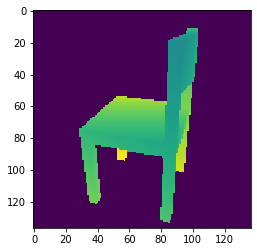

<Figure size 432x432 with 0 Axes>

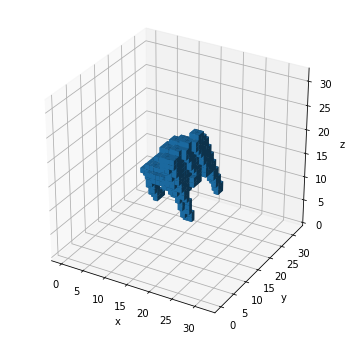

In [35]:
from pointnet2.models import Pointnet2ClsSSG as Pointnet
from models import Discrete_decoder, Mapping

# b n 3 -> b 256 1
pt2_encoder = Pointnet(input_channels=0, num_classes=1, use_xyz=True).to(device)
pt2_encoder.load_state_dict(torch.load(MODEL_PATH + 'discrete continuous shape/pt2_encoder.pth'))
e = pt2_encoder.eval()

discrete_decoder = Discrete_decoder(hidden_dim = 256).to(device)
discrete_decoder.load_state_dict(torch.load(MODEL_PATH + 'discrete continuous shape/discrete_decoder_model_pt.pth'))
e = discrete_decoder.eval()

mapping = Mapping(256).to(device)
mapping.load_state_dict(torch.load(MODEL_PATH + 'discrete continuous shape/mapping_pt.pth'))
e = mapping.eval()

idx = 6*24

plotImg(test_depth_dataset[idx]['depth_img_raw'][0,:,:])

point_cloud = test_depth_dataset[idx]['point_cloud'].unsqueeze(0).to(device)

out_vox = torch.sigmoid(discrete_decoder(mapping(pt2_encoder(point_cloud).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)))) > 0.5

plt.figure(figsize=(6, 6))


plotFromVoxels(out_vox.detach().cpu().numpy()[0,0,:,:,:])

In [19]:
#%matplotlib notebook

def test(img_index):
    
    data = full_dataset[img_index]
    
    plotFromVoxels(data['target_vox'].numpy()[0, :, :, :])
    
    print('azimuth: ', data['azimuth'])
    print('elevation: ', data['elevation'])
    
    plt.figure(figsize=(6, 6))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(data['depth_img'][0,:,:])
    
    with torch.no_grad():
        out_vox = torch.sigmoid(discrete_decoder(discrete_encoder(data['depth_img'].unsqueeze(0).to(device))))
        
        plotFromVoxels(out_vox[0, 0, :, :, :].cpu().numpy() > 0.5)
        
    
    return out_vox

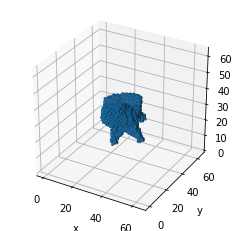

azimuth:  202.958193043
elevation:  25.1036851092


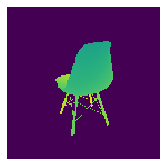

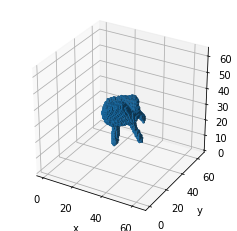

In [16]:
t = test(100)

In [17]:
target_vox = full_dataset[0]['target_vox']

## Combine discrete and continuous

In [13]:
voxsize = 64
D2R = np.pi/180.0

In [14]:
# [depth, height, width]
def get_meshgrid(depth = voxsize, height = voxsize, width = voxsize, ratio = 1.0):
    x_mesh = np.repeat(np.repeat(np.linspace(-ratio, ratio, width)[np.newaxis, :], height, axis=0)[np.newaxis, :, :], depth, axis=0)
    y_mesh = np.repeat(np.repeat(np.linspace(-ratio, ratio, height)[:, np.newaxis], width, axis=-1)[np.newaxis, :, :], depth, axis=0)
    z_mesh = np.repeat(np.repeat(np.linspace(-ratio, ratio, depth)[:, np.newaxis], height, axis= -1)[:,:, np.newaxis], width, axis=-1)
    
    x_expand = np.expand_dims(x_mesh, axis = -1)
    y_expand = np.expand_dims(y_mesh, axis = -1)
    z_expand = np.expand_dims(z_mesh, axis = -1)
    
    meshgrid = np.concatenate((x_expand, np.concatenate((y_expand, z_expand), axis = -1)), axis = -1)

    return meshgrid

In [15]:
def get_transformed_meshgrid(meshgrid, transform_matrix, depth = voxsize, height = voxsize, width = voxsize):
    meshgrid_flat = meshgrid.transpose(3, 0, 1, 2).reshape(3,-1)
    one = np.ones((1, meshgrid_flat.shape[1]))
    meshgrid_expand = np.vstack((meshgrid_flat, one))
    transformed_meshgrid = (transform_matrix @ meshgrid_expand)[0:3, :].reshape(3, depth, height, width).transpose(1, 2, 3, 0)
    return torch.tensor(transformed_meshgrid, dtype=torch.float)

In [16]:
def RotateAlongAxis(theta, a, b, c):
    
    return np.array([[a**2*(1-np.cos(D2R*theta)) + np.cos(D2R*theta), a*b*(1-np.cos(D2R*theta)) - c*np.sin(D2R*theta), a*c*(1-np.cos(D2R*theta)) + b*np.sin(D2R*theta), 0], 
                     [a*b*(1-np.cos(D2R*theta)) + c*np.sin(D2R*theta), b**2*(1-np.cos(D2R*theta)) + np.cos(D2R*theta), b*c*(1-np.cos(D2R*theta)) - a*np.sin(D2R*theta), 0], 
                     [a*c*(1-np.cos(D2R*theta)) - b*np.sin(D2R*theta), b*c*(1-np.cos(D2R*theta)) + a*np.sin(D2R*theta), c**2*(1-np.cos(D2R*theta)) + np.cos(D2R*theta), 0], 
                     [0, 0, 0, 1]])

In [17]:
def get_transformed_vox(vox_torch, azimuth, elevation):
    meshgird = get_transformed_meshgrid(get_meshgrid(voxsize, voxsize, voxsize), get_transform_matrix(azimuth, elevation), voxsize, voxsize, voxsize)
    transformedVox = F.grid_sample(vox_torch, meshgird.unsqueeze(0), mode='bilinear', padding_mode='zeros') > 0
    
    return transformedVox[0]

In [18]:
def get_relative_transform_matrix(azimuth_1, elevation_1, azimuth_2, elevation_2):
    
    rot_m = RotateAlongAxis(elevation_1, 0, 0, 1) @ RotateAlongAxis(azimuth_1, 1, 0, 0)  @ RotateAlongAxis(azimuth_2, 1, 0, 0) @ RotateAlongAxis(elevation_2, 0, 0, 1)
    
    scale = 1
    #scale = 1/np.sqrt(3)
    sca_m = np.array([[scale, 0, 0, 0],
                      [0, scale, 0, 0],
                      [0, 0, scale, 0],
                      [0, 0, 0, 1]])
    
    return rot_m @ sca_m

In [19]:
def get_relative_transformed_vox(vox_torch, azimuth_1, elevation_1, azimuth_2, elevation_2):
    meshgird = get_transformed_meshgrid(get_meshgrid(voxsize, voxsize, voxsize), 
                                        get_relative_transform_matrix(azimuth_1, elevation_1, azimuth_2, elevation_2), 
                                        voxsize, voxsize, voxsize).to(device)
    transformedVox = F.grid_sample(vox_torch, meshgird.unsqueeze(0), mode='bilinear', padding_mode='zeros')
    
    return transformedVox

In [20]:
# [depth, height, width]
def get_projection_meshgrid(depth = voxsize, height = voxsize, width = voxsize, ratio = 1.0):
    x_mesh = np.repeat(np.repeat(np.linspace(-ratio, ratio, width)[np.newaxis, :], height, axis=0)[np.newaxis, :, :], depth, axis=0)
    y_mesh = np.repeat(np.repeat(np.linspace(-2*ratio, 0, height)[:, np.newaxis], width, axis=-1)[np.newaxis, :, :], depth, axis=0)
    z_mesh = np.repeat(np.repeat(np.linspace(-ratio, ratio, depth)[:, np.newaxis], height, axis= -1)[:,:, np.newaxis], width, axis=-1)
    
    x_expand = np.expand_dims(x_mesh, axis = -1)
    y_expand = np.expand_dims(y_mesh, axis = -1)
    z_expand = np.expand_dims(z_mesh, axis = -1)
    
    meshgrid = np.concatenate((x_expand, np.concatenate((y_expand, z_expand), axis = -1)), axis = -1)

    return meshgrid

In [21]:
def get_projected_vox(vox_torch, distance):
    
    # camera distance to object
    dis_m = np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, CAM_MAX_DIST*distance],
                      [0, 0, 0, 1]])
    
    
    projection_meshgird = get_transformed_meshgrid(get_projection_meshgrid(voxsize, voxsize, voxsize),
                                        RotateAlongAxis(90, 1, 0, 0) @ dis_m @ projection @ sca_m @ RotateAlongAxis(90, 1, 0, 0),
                                        voxsize, voxsize, voxsize).to(device)
    projected_vox = F.grid_sample(vox_torch, 
                                  projection_meshgird.unsqueeze(0), 
                                  mode='bilinear', 
                                  padding_mode='zeros')
    
    return projected_vox

In [22]:
def getLossIndex(depth_img):
    depth_target = ((depth_img + 1)*31).long()
    depth_target = torch.clamp(depth_target, 0, 63)
    
    # indice at the depth\
    row, col = np.indices((64, 64))
    depth_index = torch.zeros((64, 64, 64)).byte()
    depth_index[torch.LongTensor(row), torch.LongTensor(col), depth_target] = 1
    depth_index = torch.flip(torch.rot90(torch.rot90(depth_index, k=1, dims=[2, 1]), k = 1, dims=[0, 2]), [2])
    depth_index[:, 0, :] = 0
    
    # silhouette index
    silhouette_index = torch.sum(depth_index, dim = 1) != 1
    silhouette_index = silhouette_index.unsqueeze(0)
    silhouette_index = silhouette_index.expand(64,-1,-1).transpose(0, 1)
    
    # indice closer than depth
    close_index = torch.zeros((64, 64, 64)).byte()
    tmp = torch.t(torch.rot90(depth_target, -1, [-2,-1])[torch.sum(depth_index, 1).bool()].expand(64, -1)) > torch.arange(0, 64)
    
    close_index[torch.sum(depth_index, 1).bool()] = tmp.byte()
    close_index = torch.transpose(close_index, 1, 2)
    
    
    unobs_index = torch.ones(64, 64, 64).byte()
    unobs_index[depth_index.bool()] = 0
    unobs_index[close_index.bool()] = 0
    
    return depth_index, close_index, silhouette_index, unobs_index

In [80]:
import pyrender

# parameters
F_MM = 35.  # Focal length
PIXEL_ASPECT_RATIO = 1.
CAM_MAX_DIST = 1.75
SENSOR_SIZE_MM = 32.
RESOLUTION_PCT = 100.

img_w = 137
img_h = 137

scale = RESOLUTION_PCT / 100
f_u = F_MM * img_w * scale / SENSOR_SIZE_MM
f_v = F_MM * img_h * scale * PIXEL_ASPECT_RATIO / SENSOR_SIZE_MM
u_0 = img_w * scale / 2
v_0 = img_h * scale / 2


pc = pyrender.IntrinsicsCamera(f_u, f_v, u_0, v_0, znear=0.15*CAM_MAX_DIST, zfar=1.15*CAM_MAX_DIST)
projection = pc.get_projection_matrix(img_w, img_h)
# inverse y axis
projection[1, 1] = -projection[1, 1]

# rescale back to full grid
scale = 1/np.sqrt(3)*0.8
sca_m = np.array([[scale, 0, 0, 0],
                      [0, scale, 0, 0],
                      [0, 0, scale, 0],
                      [0, 0, 0, 1]])

<IPython.core.display.Javascript object>


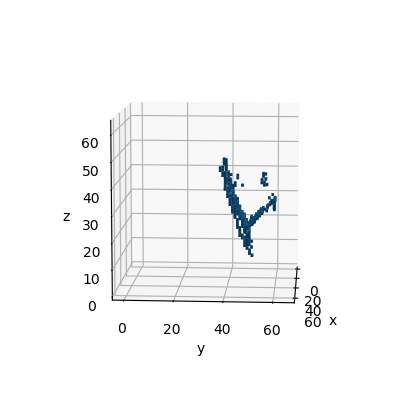

<IPython.core.display.Javascript object>


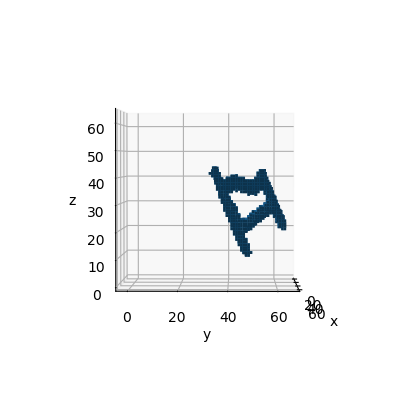

In [81]:
idx_from = 700
idx_to = 703

depth_input = full_dataset[idx_from]['depth_img'].unsqueeze(0)
target_vox = full_dataset[idx_from]['target_vox']
azimuth_1 = full_dataset[idx_from]['azimuth']
elevation_1 = full_dataset[idx_from]['elevation']


depth_img = full_dataset[idx_to]['depth_img'].unsqueeze(0)

#plt.figure(figsize=(6, 6))
#plt.subplot(1,2,1)
#plt.axis('off')
#plt.imshow(depth_input[0,0,:,:])


ground_truth_vox = full_dataset[idx_to]['target_vox']
azimuth_2 = full_dataset[idx_to]['azimuth']
elevation_2 = full_dataset[idx_to]['elevation']
distance = full_dataset[idx_to]['distance']

#plt.figure(figsize=(6, 6))
#plt.subplot(1,2,1)
#plt.axis('off')
#plt.imshow(depth_img[0, 0,:,:])

z = discrete_encoder(depth_input.to(device))
out_vox = torch.sigmoid(discrete_decoder(z))

#plotFromVoxels(out_vox.detach().cpu().numpy()[0, 0, :, :, :] > 0.5)

depth_index, close_index = reproject_depth(depth_img)
plotFromVoxels(depth_index.numpy())

# transform to target pose
transformed_vox = get_relative_transformed_vox(target_vox.unsqueeze(0).to(device), -azimuth_1, -elevation_1, azimuth_2, elevation_2)
#plotFromVoxels(transformed_vox.detach().cpu().numpy()[0, 0, :, :, :] > 0.5)

# projection based on camera matrix
projected_vox = get_projected_vox(transformed_vox, distance)
plotFromVoxels(projected_vox.detach().cpu().numpy()[0, 0, :, :, :] > 0.5)

## compute depth
#arg = np.argmax(projected_vox.numpy()[0, 0, :, :, :], axis = 1)
#img = np.rot90(arg.astype(float)/31, axes=(-2,-1))

#plotFromVoxels(ground_truth_vox.numpy()[0, :, :, :] > 0.5)


#plt.subplot(1,2,2)
#plt.axis('off')
#plt.imshow(img)

In [82]:
def project_vox(vox_torch, azimuth_1, elevation_1, azimuth_2, elevation_2, distance):
    
    # transform to target pose
    transformed_vox = get_relative_transformed_vox(vox_torch, -azimuth_1, -elevation_1, azimuth_2, elevation_2)
    
    # projection based on camera matrix
    projected_vox = get_projected_vox(transformed_vox, distance)
    
    return projected_vox

In [83]:
# 224x224
def reproject_depth(depth_img):
    
    down_sample_64 = torch.nn.MaxPool2d(kernel_size=7, stride=7, padding=0)
    depth_img[depth_img < 0] = -1
    depth_img = nn.functional.interpolate(depth_img.unsqueeze(0), size=448, mode='nearest').squeeze(0)
    depth_img_64 = down_sample_64(depth_img)[0,0,:,:]
    depth_index, close_index ,_,_ = getLossIndex(depth_img_64)
    
    return depth_index, close_index

In [84]:
# custom depth consistency loss

from torch.autograd import Function
from torch.autograd.function import once_differentiable

class DepthConsistencyLoss(Function):

    @staticmethod
    def forward(ctx, out_vox, depth_index, close_index):
        
        # out_vox shape n x 1 x 32 x 32 x 32
        # depth_index shape n x 32 x 32 x 32
        # close_index shape n x 32 x 32 x 32
        
        ctx.save_for_backward(out_vox)
        
        vox = out_vox.squeeze(1)
        ctx.depth_index = depth_index
        ctx.close_index = close_index
        
        loss = torch.zeros_like(depth_index, dtype=torch.float).to(device)
        
        #bce form
        loss[depth_index.bool()] = -torch.log(vox[depth_index.bool()])
        loss[close_index.bool()] = -torch.log(1-vox[close_index.bool()])
        
        return torch.sum(loss) / (torch.sum(depth_index) + torch.sum(close_index))
        
    @staticmethod
    @once_differentiable
    def backward(ctx, grad_output):
        
        out_vox, = ctx.saved_tensors
        
        vox = out_vox.squeeze(1)
        grad = torch.zeros_like(ctx.depth_index, dtype=torch.float).to(device)
        
        #bce form
        grad[ctx.depth_index.bool()] = -1/vox[ctx.depth_index.bool()]
        grad[ctx.close_index.bool()] = 1/(1-vox[ctx.close_index.bool()])
        
        return grad.unsqueeze(1), None, None, None

In [85]:
import vis_utils
import models
import dataIO
import pymesh

discrete_encoder = Discrete_encoder(128).to(device)
discrete_encoder.load_state_dict(torch.load(MODEL_PATH + 'discrete continuous shape/discrete_encoder_model.pth'))
e = discrete_encoder.eval()

discrete_decoder = Discrete_decoder(128).to(device)
discrete_decoder.load_state_dict(torch.load(MODEL_PATH + 'discrete continuous shape/discrete_decoder_model.pth'))
e = discrete_decoder.eval()

continuous = Continuous().to(device)
continuous.load_state_dict(torch.load(MODEL_PATH + 'discrete continuous shape/continuous_model.pth'))
e = continuous.eval()

<IPython.core.display.Javascript object>


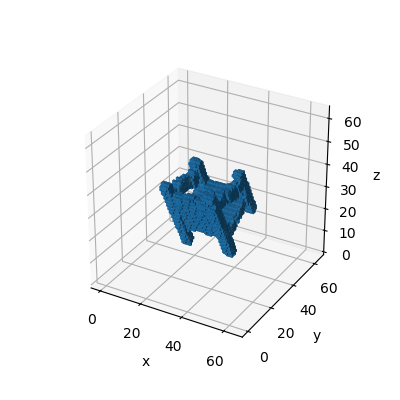

<IPython.core.display.Javascript object>


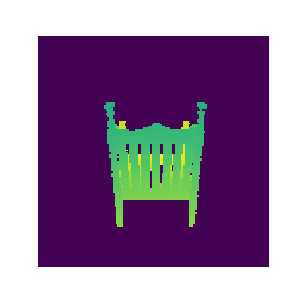

<IPython.core.display.Javascript object>


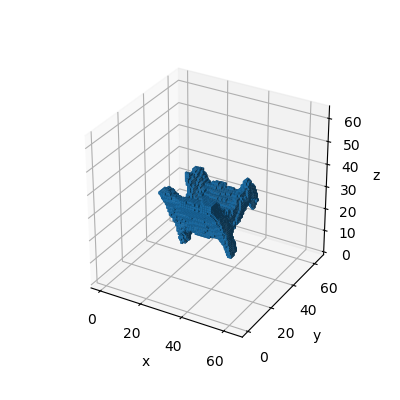

Data generation
Success generation
Marching cube


<IPython.core.display.Javascript object>


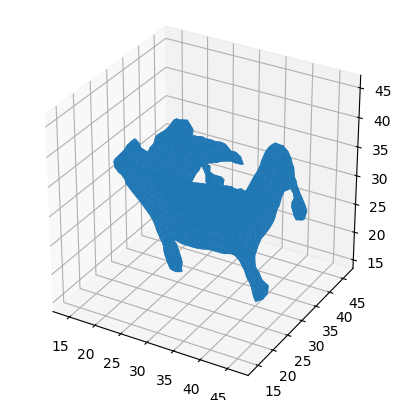

<IPython.core.display.Javascript object>


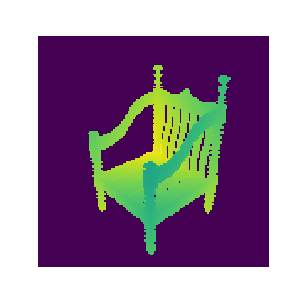

<IPython.core.display.Javascript object>


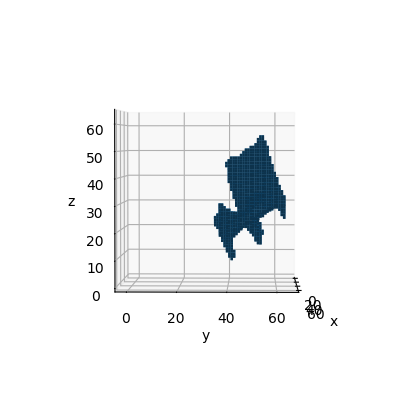

<IPython.core.display.Javascript object>


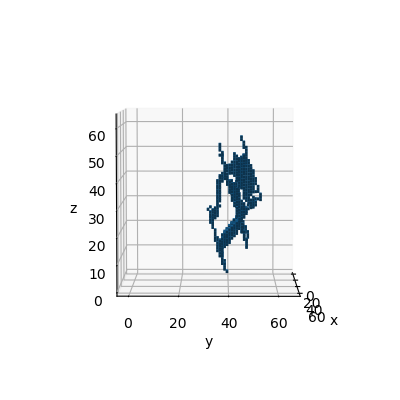

<IPython.core.display.Javascript object>


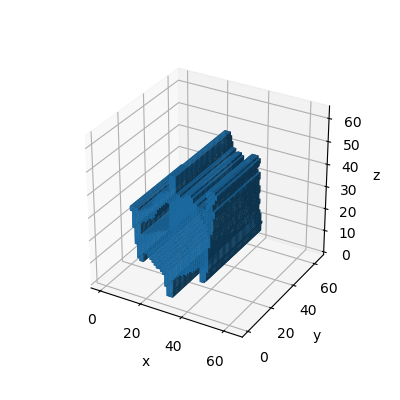

In [86]:
%matplotlib notebook

lr = 3e-4
idx_from = 703
idx_to = 700

data_from = full_dataset[idx_from]
data_to = full_dataset[idx_to]

plotFromVoxels(data_from['target_vox'].numpy()[0,:,:,:])

z = discrete_encoder(data_from['depth_img'].unsqueeze(0).to(device))
out_vox = torch.sigmoid(discrete_decoder(z))


plt.figure(figsize=(3, 3))
plt.axis('off')
plt.imshow(data_from['depth_img'][0,:,:])

plotFromVoxels(out_vox[0,0,:,:,:].cpu().detach().numpy() > 0.5)

# mesh
mesh = vis_utils.generate_mesh(continuous, out_vox, z, device)
dataIO.plotFromVF(mesh.vertices, mesh.faces)

azimuth_1 = data_from['azimuth']
elevation_1 = data_from['elevation']
depth_img = data_to['depth_img']
azimuth_2 = data_to['azimuth']
elevation_2 = data_to['elevation']
distance = data_to['distance']

plt.figure(figsize=(3, 3))
plt.axis('off')
plt.imshow(depth_img[0,:,:])

projected_vox = project_vox(out_vox, azimuth_1, elevation_1, azimuth_2, elevation_2, distance)
depth_index, close_index = reproject_depth(depth_img.unsqueeze(0))

plotFromVoxels(projected_vox[0,0,:,:,:].cpu().detach().numpy() > 0.5)
plotFromVoxels(depth_index.cpu().detach().numpy() > 0.5)
plotFromVoxels(close_index.cpu().detach().numpy() > 0.5)

Initial loss:  0.04712304100394249
0.04719085991382599
0.04955355077981949
0.053753118962049484
0.04936416447162628
0.04959220811724663
0.04652218148112297
0.04629270359873772
0.04493561387062073
0.04480792582035065


<IPython.core.display.Javascript object>


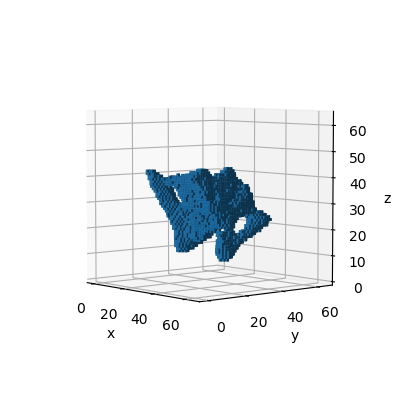

In [91]:
# Finement only optimized the observed part
# It requires multiple depth image to joint optimize z

for i in range(10):

    projected_vox = project_vox(out_vox, azimuth_1, elevation_1, azimuth_2, elevation_2, distance)
    depth_index, close_index = reproject_depth(depth_img.unsqueeze(0))
    
    loss = DepthConsistencyLoss.apply(projected_vox, 
                                      depth_index.unsqueeze(0).to(device), 
                                      close_index.unsqueeze(0).to(device))
    if i == 0:
        print("Initial loss: ", loss.item())
    else:
        print(loss.item())
    
    z.retain_grad()
    loss.backward(retain_graph=True)
    #print("Latent grad: ", torch.sum(z.grad))
    
    z.data -= lr * z.grad
    
    out_vox = torch.sigmoid(discrete_decoder(z))
    
    z.grad.zero_()
    
plotFromVoxels(out_vox[0,0,:,:,:].cpu().detach().numpy() > 0.5)

Data generation
Success generation
Marching cube


<IPython.core.display.Javascript object>


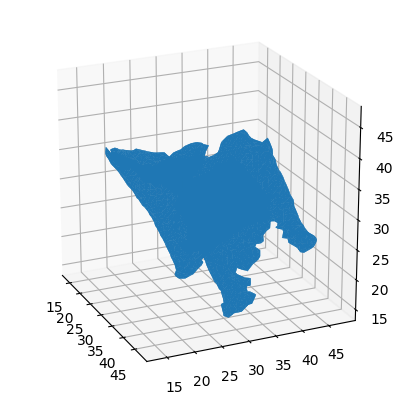

In [90]:
# mesh
mesh = vis_utils.generate_mesh(continuous, out_vox, z, device)
dataIO.plotFromVF(mesh.vertices, mesh.faces)

In [ ]:
#plt.figure(figsize=(6, 6))
#plt.subplot(1,2,1)
#plt.axis('off')
#plt.imshow(depth_img[0, 0,:,:])

In [34]:
depth_input = full_dataset[idx_from]['depth_img'].unsqueeze(0)
target_vox = full_dataset[idx_from]['target_vox']
azimuth_1 = full_dataset[idx_from]['azimuth']
elevation_1 = full_dataset[idx_from]['elevation']


depth_img = full_dataset[idx_to]['depth_img'].unsqueeze(0)
ground_truth_vox = full_dataset[idx_to]['target_vox']
azimuth_2 = full_dataset[idx_to]['azimuth']
elevation_2 = full_dataset[idx_to]['elevation']
distance = full_dataset[idx_to]['distance']

In [ ]:
import pyrender

# parameters
F_MM = 35.  # Focal length
PIXEL_ASPECT_RATIO = 1.
CAM_MAX_DIST = 1.75
SENSOR_SIZE_MM = 32.
RESOLUTION_PCT = 100.

img_w = 137
img_h = 137

scale = RESOLUTION_PCT / 100
f_u = F_MM * img_w * scale / SENSOR_SIZE_MM
f_v = F_MM * img_h * scale * PIXEL_ASPECT_RATIO / SENSOR_SIZE_MM
u_0 = img_w * scale / 2
v_0 = img_h * scale / 2


pc = pyrender.IntrinsicsCamera(f_u, f_v, u_0, v_0, znear=0.15*CAM_MAX_DIST, zfar=1.15*CAM_MAX_DIST)
projection = pc.get_projection_matrix(img_w, img_h)

# rescale back to full grid
scale = 1/np.sqrt(3) * 0.8
sca_m = np.array([[scale, 0, 0, 0],
                      [0, scale, 0, 0],
                      [0, 0, scale, 0],
                      [0, 0, 0, 1]])



con = np.array([[1, 0, 0, 0], 
                [0, 0, 1, 0], 
                [0, 1, 0, 0], 
                [0, 0, 0, 1]])

projection = projection @ con

projection

def get_projected_vox(vox_torch, distance):
    # -z -y -x
    # camera distance to object
    dis_m = np.array([[1, 0, 0, 0],
                      [0, 1, 0, -0.5],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])
    
    projection_meshgird = get_transformed_meshgrid(get_projection_meshgrid(voxsize, voxsize, voxsize),
                                        sca_m @ RotateAlongAxis(90, 1, 0, 0) @ projection @ dis_m,
                                        voxsize, voxsize, voxsize).to(device)
    projected_vox = F.grid_sample(vox_torch, 
                                  projection_meshgird.unsqueeze(0), 
                                  mode='bilinear', 
                                  padding_mode='zeros')
    
    return projected_vox

projected = get_projected_vox(target_vox.to(device).unsqueeze(0).unsqueeze(0), distance)